<div style="border:solid black 2px; padding: 20px" class="alert alert-success">
    
# General feedback v.1 *Project Accepted*

Terima kasih banyak telah mengirimkan proyek Anda! 
<br>
    
Secara keseluruhan, proyek Anda **SANGAT** mengesankan. Semoga apa yang kamu pelajari dalam project ini dapat membantu meningkatkan kemampuanmu. Pertahankan apa yang sudah bagus, dan tingkatkan apa yang menurutmu masih perlu ditingkatkan. Semoga berhasil pada project selanjutnya yaa :)

**TETAP SEMANGAT!!**
    
</div>

Rusty Bargain adalah perusahaan jual beli mobil bekas yang sedang mengembangkan sebuah aplikasi untuk menarik pembeli baru. Dalam aplikasi tersebut, kamu bisa dengan cepat mengetahui nilai pasar mobilmu. Kamu memiliki akses ke data historis, spesifikasi teknis kendaraan, versi model kendaraan, dan harga kendaraan. Tugasmu adalah membuat suatu model yang mampu menentukan nilai pasar mobil.
Rusty Bargain tertarik pada:

- kualitas prediksi;
- kecepatan model dalam memprediksi;
- waktu yang diperlukan untuk melatih model

## Persiapan Data

### Loading Data

In [1]:
# required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

import warnings

warnings.filterwarnings("ignore")

In [2]:
# load the data
df = pd.read_csv("/datasets/car_data.csv", parse_dates=True, infer_datetime_format=True)
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [3]:
# Mencetak info tentang data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# Menghitung jumlah nilai yang hilang dan persentasenya di setiap kolom setiap file data
def missing_data(list_of_dfs, list_of_names=None):
    for i in range(len(list_of_dfs)):
        df = list_of_dfs[i]
        col_names = df.columns.tolist()
        na_per_col = df.isna().sum().tolist()
        na_percentage = (df.isna().sum() / len(df) * 100).tolist()
        if list_of_names != None:
            print("=" * 20, "Missing values of", list_of_names[i], "=" * 20)
        display(
            pd.DataFrame(
                list(zip(na_per_col, na_percentage)),
                columns=["Number of missings", "% of missings"],
                index=col_names,
            ).style.background_gradient(axis=0)
        )


# Menerapkan fungsi nya
missing_data([df])

,Number of missings,% of missings
DateCrawled,0,0.000000
Price,0,0.000000
VehicleType,37490,10.579368
RegistrationYear,0,0.000000
Gearbox,19833,5.596709
Power,0,0.000000
Model,19705,5.560588
Mileage,0,0.000000
RegistrationMonth,0,0.000000
FuelType,32895,9.282697


In [5]:
# Memeriksa jumlah baris yang diduplikasi
display(df.duplicated().sum())
print(f"Percentage of duplicated rows is {df.duplicated().sum()/len(df):.2%}.")

262

Percentage of duplicated rows is 0.07%.


In [6]:
# retreiev which rows were repeated
duplicates = df.duplicated(keep=False)
df.loc[duplicates].sort_values(["DateCrawled"])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
90786,01/04/2016 05:02,6199,coupe,1999,manual,193,3er,150000,5,petrol,bmw,no,01/04/2016 00:00,0,99974,07/04/2016 06:15
87112,01/04/2016 05:02,6199,coupe,1999,manual,193,3er,150000,5,petrol,bmw,no,01/04/2016 00:00,0,99974,07/04/2016 06:15
45825,01/04/2016 10:38,3499,small,2005,manual,86,getz,50000,5,petrol,hyundai,no,01/04/2016 00:00,0,47800,07/04/2016 06:46
142496,01/04/2016 10:38,3499,small,2005,manual,86,getz,50000,5,petrol,hyundai,no,01/04/2016 00:00,0,47800,07/04/2016 06:46
12578,01/04/2016 12:57,1499,wagon,1995,manual,150,5er,150000,6,petrol,bmw,no,01/04/2016 00:00,0,25821,07/04/2016 09:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68628,31/03/2016 19:51,999,small,1998,manual,60,corsa,150000,5,petrol,opel,no,31/03/2016 00:00,0,85111,06/04/2016 14:18
228351,31/03/2016 20:25,9600,sedan,2006,manual,226,focus,125000,4,petrol,ford,no,31/03/2016 00:00,0,55469,06/04/2016 14:15
27192,31/03/2016 20:25,9600,sedan,2006,manual,226,focus,125000,4,petrol,ford,no,31/03/2016 00:00,0,55469,06/04/2016 14:15
30499,31/03/2016 23:51,5999,wagon,2007,manual,120,astra,150000,3,gasoline,opel,no,31/03/2016 00:00,0,95482,07/04/2016 00:17


Masalah yang teridentifikasi sejauh ini:

1. Nama kolom harus menggunakan huruf kecil
2. Tipe data beberapa kolom kurang sesuai
3. 5 kolom memiliki nilai yang hilang dan kolom pangkat memiliki nol, harus ditangani.
4. 262 nilai duplikat untuk saat ini (setelah mengisi nilai yang hilang, nilai ini mungkin bertambah)

### Preprocessing

#### Nama Kolom


In [8]:
# convert column names to lowercase
df.columns = df.columns.str.lower().str.strip()
df.head(1)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16


#### Tipe Kolom

In [9]:
df[["datecrawled", "datecreated", "lastseen"]] = df[
    ["datecrawled", "datecreated", "lastseen"]
].apply(pd.to_datetime, infer_datetime_format=True)
df.dtypes

datecrawled          datetime64[ns]
price                         int64
vehicletype                  object
registrationyear              int64
gearbox                      object
power                         int64
model                        object
mileage                       int64
registrationmonth             int64
fueltype                     object
brand                        object
notrepaired                  object
datecreated          datetime64[ns]
numberofpictures              int64
postalcode                    int64
lastseen             datetime64[ns]
dtype: object

#### Missing Values

In [10]:
columns_with_missing_values = [
    "vehicletype",
    "gearbox",
    "model",
    "fueltype",
    "notrepaired",
]
df[columns_with_missing_values] = df[columns_with_missing_values].fillna("unknown")
df.isna().sum()

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
mileage              0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

#### Duplicates

In [11]:
print(
    f"Number of duplicated rows {df.duplicated().sum()} and total number of rows {df.shape[0]}."
)
df = df.drop_duplicates()
print()
print("=" * 20, "After dropping ducplicates", "=" * 20)
print(
    f"Number of duplicated rows {df.duplicated().sum()} and total number of rows {df.shape[0]}."
)

Number of duplicated rows 262 and total number of rows 354369.

==================== After dropping ducplicates ====================
Number of duplicated rows 0 and total number of rows 354107.


#### Membuat Kolom Umur


In [12]:
# periksa statistik deskriptif kolom tahun pendaftaran dan tanggal
df.registrationyear.describe(), df.datecreated.dt.year.describe()

(count    354107.000000
 mean       2004.235355
 std          90.261168
 min        1000.000000
 25%        1999.000000
 50%        2003.000000
 75%        2008.000000
 max        9999.000000
 Name: registrationyear, dtype: float64,
 count    354107.000000
 mean       2015.999924
 std           0.009049
 min        2014.000000
 25%        2016.000000
 50%        2016.000000
 75%        2016.000000
 max        2016.000000
 Name: datecreated, dtype: float64)

In [13]:
# Memilih tahun di bawah 1900 dan di atas 'tanggal dibuat'
condition = (df["registrationyear"] > df["datecreated"].dt.year) | (
    df["registrationyear"] < 1900
)
display(len(df[condition]) / len(df) * 100)
print()

# Memilih data yang tidak memiliki kondisi di atas
df = df[~(condition)]

# Menghitung umur dari mesin
df["vehicleage"] = df["datecreated"].dt.year - df["registrationyear"]

# Mengecheck hasil
df.head(2)

4.121635550836329

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen,vehicleage
0,2016-03-24 11:52:00,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-07-04 03:16:00,23
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-07-04 01:46:00,5


### Kesimpulan Sementara

Data dengan 354369 baris dan 16 kolom telah diimpor dan diperiksa, observasi/perubahan berikut dilakukan:
1. Kolom nama data dalam huruf campuran, semuanya diubah menjadi huruf kecil.
2. Kolom `datecrawled`, `datecreated`, dan `lastseen` berisi tanggal tetapi dimuat sebagai tipe data objek. Mereka dikonversi ke tipe data datetime pandas.
3. Kolom tipe `vehicletype`, `gearbox`, `model`, `fueltype`, and `notrepaired` mengandung nilai yang hilang. Semua kolom ini berisi tipe data kategorikal. Oleh karena itu, semua nilai yang hilang diisi sebagai `"Unknown"`.
4. Total 262 baris diduplikasi dalam data asli. Ditemukan bahwa mereka adalah duplikat yang identik semua nya dihilangkan.
5. Kolom baru yang berisi `vehicleage`, dibuat menggunakan kolom `datecreated` and `registrationyear`. 

Namun, pada langkah ini, terlihat bahwa data mengandung kesalahan pada kolom `registrationyear`, ada tahun yang paling rendah `1000` dan paling tinggi `9999`. Semua tahun lebih kecil dari 1900 (tahun ketika mobil menjadi komersial) dan lebih tinggi dari tahun pembuatan tanggal profil dibatalkan. Jumlah baris yang dihilangkan sekitar 4% dari data. Semua kesalahan yang disebutkan mungkin berasal dari alasan teknis, kesalahan manusia (salah ketik), atau selama perayapan web, penggabungan kumpulan data, dll.

## EDA

Mari mengenal data lebih jauh dengan memvisualisasikan datanya dengan membuat plot beberapa diagram.

### Kolom Numerikal

In [14]:
# Memilih semua kolom numerikal dari data
numerical_cols = ["price", "power", "mileage", "vehicleage"]

# Menampilkan statistik deskriptif kolom numerik
df[numerical_cols].describe()

,price,power,mileage,vehicleage
count,339512.000000,339512.000000,339512.000000,339512.000000
mean,4471.106815,110.998374,128086.753929,13.518061
std,4546.229568,186.945091,37896.907472,7.091876
min,0.000000,0.000000,5000.000000,0.000000
25%,1099.000000,69.000000,125000.000000,9.000000
50%,2799.000000,105.000000,150000.000000,13.000000
75%,6500.000000,143.000000,150000.000000,17.000000
max,20000.000000,20000.000000,150000.000000,106.000000


Sepertinya masih memiliki kesalahan pada data kami. Salah satu nya sebuah mobil tidak bisa mempunyai tenaga setinggi 20000. Sedikit pencarian di google menghasilkan bahwa mobil dengan tenaga tertinggi sampai saat ini adalah 1500

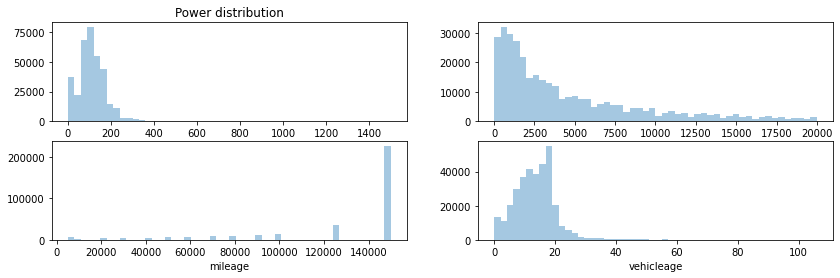

In [15]:
# Membuat histograms dari semua kolom numerik 
fig, ax = plt.subplots(2, 2, figsize=(14, 4))
sns.distplot(df["power"], kde=False, hist_kws={"range": (0, 1500)}, ax=ax[0, 0])
ax[0, 0].set_title("Power distribution")
sns.distplot(df["price"], kde=False, ax=ax[0, 1])
sns.distplot(df["mileage"], kde=False, hist_kws={"range": (5000, 150000)}, ax=ax[1, 0])
sns.distplot(df["vehicleage"], kde=False, ax=ax[1, 1])

plt.show()

In [16]:
# Menghitung outliers untuk kolom 'power'
(
    df["power"].quantile(0.75)
    + (df["power"].quantile(0.75) - df["power"].quantile(0.25)) * 1.5
)

254.0

8038 0.12400150804684369


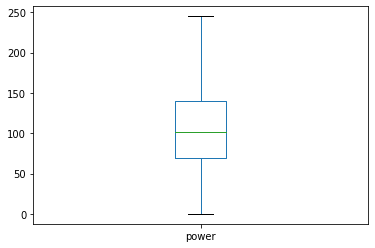

In [17]:
# Berapa banyak baris dan berapa presentase di total outliers kolom 'power'
print(len(df[df["power"] > 245]), len(df[df["power"] > 500]) / len(df) * 100)

# Memilih semua baris untuk 'power' dibawah dari 245
df = df[~(df["power"] > 245)]

# plot the boxplot
df["power"].plot(kind="box")
plt.show()

### Kolom Kategorikal

In [18]:
# Statistik deskriptif kolom kategori
categorical_cols = ["vehicletype", "gearbox", "model", "fueltype", "brand"]
df[categorical_cols].describe()

,vehicletype,gearbox,model,fueltype,brand
count,331474,331474,331474,331474,331474
unique,9,3,250,8,40
top,sedan,manual,golf,petrol,volkswagen
freq,88048,255167,27315,203857,72503


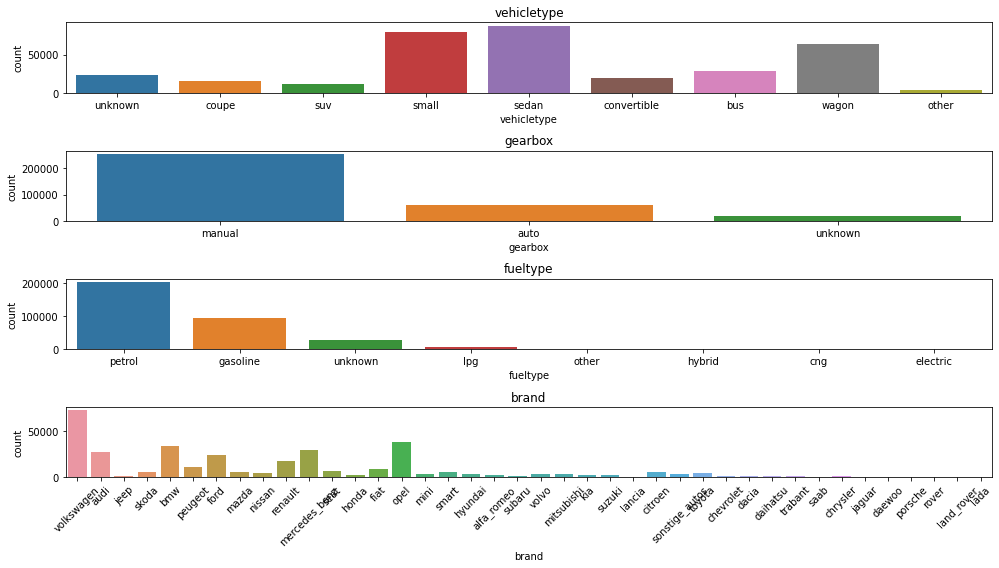

In [19]:
# Menampilkan plots number dari tipe vehicle, gearbox, fueltype dan car brand
fig, ax = plt.subplots(4, 1, figsize=(14, 8))
for i, j in enumerate(["vehicletype", "gearbox", "fueltype", "brand"]):
    sns.countplot(df[j], ax=ax[i])
    ax[i].set_title(j)
ax[3].tick_params(
    axis="x",
    rotation=45,
)
plt.tight_layout()
plt.show()

### Kesimpulan Sementara 

Selama `EDA`, diamati adanya kesalahan pada kolom pangkat, yang berisi nilai horsepower setinggi 20.000. Semua nilai di atas Q3+IQR*1.5 dihilangkan (hanya 0,12% dari data).

Teramati bahwa **yang paling banyak terjual**:

1. merek: Volkswagen
2. model: golf
3. vehicle type: sedan
4. gearbox: manual (lebih dari dua pertiga dari semuanya)
5. fuel type: bensin (sekitar dua pertiga dari semuanya)

## Model Training 

Di bagian ini akan melatih model yang berbeda, dan menyesuaikan beberapa hyperparameter, jika memungkinkan tentunya. Algoritma berikut yang akan kita gunakan:

1. Regresi linier
2. RandomForestRegressor (dengan n_estimators dan max_ depth yang berbeda)
3. CatBoostRegressor (dengan jumlah iterasi dan kedalaman berbeda)
4. LightBGMRegressor (dengan n_estimaros dan max_ depth berbeda)
5. XGBoostRegressor (dengan parameter default)

Namun, sebelum itu, kami harus menyebutkan bahwa kami tidak memerlukan semua kolom data. Karena beberapa kolom tidak akan menambah nilai prediksi. Oleh karena itu akan memilih kolom yang paling penting.

In [20]:
# Memilih kolom yang mana penting untuk modeling
selected_cols = [
    "price",
    "vehicletype",
    "gearbox",
    "power",
    "model",
    "mileage",
    "fueltype",
    "brand",
    "vehicleage",
]
df = df[selected_cols]

# Melihat shape dari dataframe yang baru
df.shape

(331474, 9)

In [21]:
# Menententukan kolom kategorikal dan numerik, yang akan digunakan melalui pelatihan algoritma
categorical_columns = ["vehicletype", "gearbox", "model", "fueltype", "brand"]
numerical_columns = ["power", "mileage", "vehicleage"]

### Linier Regression 

In [22]:
# Untuk regresi one hot encoding  bekerja dengan baik
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.shape

# Mendapatkan target dan feature columns
X = df_ohe.drop("price", axis=1)
y = df_ohe["price"]

# split into training dan testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=234
)

# Penskalaan sangat penting untuk model regresi
numerical_columns = ["power", "mileage", "vehicleage"]
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [23]:
%%time
#linear regression model, hasil train dan predict
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

CPU times: user 15.5 s, sys: 2.06 s, total: 17.6 s
Wall time: 17.6 s


LinearRegression()

In [24]:
%%time
# Memprediksi target dan menghitung RMSE dan memeriksa waktu untuk prediksi
y_pred = lr_model.predict(X_test)
#Scores
print(f'The RMSE score of the linear regression model is {(mean_squared_error(y_test, y_pred))**0.5}.')

The RMSE score of the linear regression model is 2766.0508416273915.
CPU times: user 76.4 ms, sys: 36.6 ms, total: 113 ms
Wall time: 77.7 ms


### Random Forest Regression

Disini akan menggunakan kelas sklearn `OrindalEncoding` untuk menyandikan kolom kategorikal, ini bekerja lebih baik daripada OHE untuk algoritma berbasis pohon. Data yang disiapkan pada langkah ini akan digunakan untuk `RandomForest`, `LightGBM` dan `XGBoost`. Untuk `Catboost`  akan menyiapkan data tersendiri, karena bisa menangani data kategorikal.

In [25]:
# Mendapatkan kolom kategorikal
df_lbe = df.copy()

# Memmbangun pembuat enkode
encoder = OrdinalEncoder()

# Menyandikan kolom kategorikal dan mengubah nilai dalam kerangka data
encoded = encoder.fit_transform(df_lbe[categorical_columns])
df_lbe[categorical_columns] = encoded

# Memeriksa df baru
df_lbe.head(2)

,price,vehicletype,gearbox,power,model,mileage,fueltype,brand,vehicleage
0,480,7.0,1.0,0,116.0,150000,6.0,38.0,23
1,18300,2.0,1.0,190,227.0,125000,2.0,1.0,5


In [26]:
# Mendapatkan kolom target dan feature dari df_lbe
X = df_lbe.drop("price", axis=1)
y = df_lbe["price"]

# split into training dan testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=234
)

In [27]:
# loop untuk memeriksa optimal n_estimators
for n in [30, 50]:
    rf_model = RandomForestRegressor(n_estimators=n, n_jobs=-1, random_state=234)
    mse = cross_val_score(
        rf_model, X_train, y_train, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(
        f"The average RMSE score of the RandomForest model with {n} estimators is {avg_rmse}."
    )
    print()

# loop to menemukan nilai optimal max_depth
for n in [7, 15]:
    rf_model = RandomForestRegressor(
        n_estimators=30, max_depth=n, n_jobs=-1, random_state=234
    )
    mse = cross_val_score(
        rf_model, X_train, y_train, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(
        f"The average RMSE score of the RandomForest model with max_depth={n} is {avg_rmse}."
    )
    print()

The average RMSE score of the RandomForest model with 30 estimators is 1770.1783591307112.

The average RMSE score of the RandomForest model with 50 estimators is 1763.309984696877.

The average RMSE score of the RandomForest model with max_depth=7 is 2139.9130325012443.

The average RMSE score of the RandomForest model with max_depth=15 is 1763.9865281457915.



Jika `n_estimators` terlalu besar, skor RMSE model akan sedikit meningkat tetapi penggunaan `n_estimators` yang tinggi akan memperlambat komputasi. Demi kecepatan, akan memilih `n_estimators sebesar 50` dan `max_ depth sebesar 20`. Mari kita cari berapa banyak waktu yang diperlukan untuk model optimal dengan `RandomForestRegressor`

In [28]:
%%time
# membangun model dengan parameter optimal dan memeriksa berapa banyak waktu yang diperlukan untuk pelatihan
best_rf_model = RandomForestRegressor(n_estimators = 50, max_depth=15, n_jobs=-1, random_state=234)
best_rf_model.fit(X_train, y_train)

CPU times: user 27.9 s, sys: 22.7 ms, total: 27.9 s
Wall time: 28 s


RandomForestRegressor(max_depth=15, n_estimators=50, n_jobs=-1,
                      random_state=234)

In [29]:
%%time
# Sekarang mari kita periksa berapa banyak waktu yang diperlukan untuk prediksi dan menghitung RMSE
y_pred = best_rf_model.predict(X_test)

print(f'The RMSE score of the best RandomForestRegression model is {(mean_squared_error(y_test, y_pred))**0.5}.')

The RMSE score of the best RandomForestRegression model is 1754.4200140924252.
CPU times: user 1.01 s, sys: 7.92 ms, total: 1.02 s
Wall time: 1.01 s


### LightGBM Regressor

In [30]:
# loop untuk menemukan n_estimators yang optimal
for n in [30, 50]:
    lg_model = LGBMRegressor(n_estimators=n, random_state=234)
    mse = cross_val_score(
        lg_model, X_train, y_train, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(f"The RMSE score of the LightGBM model with {n} estimators is {avg_rmse}.")
    print()

# Loop untuk menemukan max_depth yang optimal
for n in [7, 15]:
    lg_model = LGBMRegressor(n_estimators=30, max_depth=n, random_state=234)
    mse = cross_val_score(
        lg_model, X_train, y_train, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(f"The RMSE score of the LightGBM model with max_depth={n} is {avg_rmse}.")
    print()

The RMSE score of the LightGBM model with 30 estimators is 1982.904491418236.

The RMSE score of the LightGBM model with 50 estimators is 1868.479333522558.

The RMSE score of the LightGBM model with max_depth=7 is 1989.3441819444317.

The RMSE score of the LightGBM model with max_depth=15 is 1982.904491418236.



In [31]:
%%time

# Membangun model dengan parameter optimal dan memeriksa berapa banyak waktu yang diperlukan untuk training
best_lg_model = LGBMRegressor(n_estimators=50, max_depth=15, random_state=234)
best_lg_model.fit(X_train, y_train)

CPU times: user 1.89 s, sys: 15.9 ms, total: 1.9 s
Wall time: 1.86 s


LGBMRegressor(max_depth=15, n_estimators=50, random_state=234)

In [32]:
%%time
# Memprediksi target dan memeriksa skor RMSE dan waktu yang diperlukan untuk prediksi
y_pred = best_lg_model.predict(X_test)
print(f'The RMSE score of the best LightGBM model is {(mean_squared_error(y_test, y_pred))**0.5}.')

The RMSE score of the best LightGBM model is 1888.525685137322.
CPU times: user 455 ms, sys: 0 ns, total: 455 ms
Wall time: 379 ms


### XGBoost Regressor

In [33]:
%%time
# Menghitung waktu yang dibutuhkan untuk training
xg_model = xgb.XGBRegressor()
xg_model.fit(X_train,y_train)

CPU times: user 28.9 s, sys: 68.2 ms, total: 28.9 s
Wall time: 29.3 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [34]:
%%time
# Melakukan prediksi dan periksa skor RMSE dan waktu yang diperlukan
y_pred = xg_model.predict(X_test)

print(f'The RMSE score of the XGBoost model with defualt parameters is {(mean_squared_error(y_test, y_pred))**0.5}.')

The RMSE score of the XGBoost model with defualt parameters is 1745.2050153705543.
CPU times: user 480 ms, sys: 0 ns, total: 480 ms
Wall time: 406 ms


### Catboost Regressor

In [35]:
# Mendapatkan kolom target dan feature dari df tanpa encoding
X = df.drop("price", axis=1)
y = df["price"]

# split into training dan testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=234
)

# loop untuk memeriksa number yang optimal dari iterations
for n in [30, 50]:
    cb_model = CatBoostRegressor(
        iterations=n,
        learning_rate=1,
        random_seed=234,
        silent=True,
        cat_features=categorical_columns,
    )
    mse = cross_val_score(
        cb_model, X_train, y_train, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(f"The RMSE score of the Catboost model with {n} iterations is {avg_rmse}.")
    print()

# Loop untuk memeriksa optimal number dari depth
for n in [7, 15]:
    cb_model = CatBoostRegressor(
        iterations=30,
        learning_rate=1,
        depth=n,
        random_seed=234,
        silent=True,
        cat_features=categorical_columns,
    )
    mse = cross_val_score(
        cb_model, X_train, y_train, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(f"The RMSE score of the Catboost model with depth={n} is {avg_rmse}.")
    print()

The RMSE score of the Catboost model with 30 iterations is 1858.0889667967595.

The RMSE score of the Catboost model with 50 iterations is 1826.9967002786213.

The RMSE score of the Catboost model with depth=7 is 1842.8976274074018.

The RMSE score of the Catboost model with depth=15 is 1830.9026477972693.



In [36]:
%%time

# Membangun model dengan parameter optimal dan memeriksa berapa banyak waktu yang diperlukan untuk training
best_cb_model = CatBoostRegressor(iterations=50, learning_rate=1, depth=15, random_seed=234, silent=True)
best_cb_model.fit(X_train, y_train, cat_features=categorical_columns)

CPU times: user 48.6 s, sys: 3.61 s, total: 52.2 s
Wall time: 52.5 s


In [37]:
%%time
# Memprediksi target dan memeriksa RMSE score dan time
y_pred = best_cb_model.predict(X_test)

print(f'The RMSE score of the best Catboost model is {(mean_squared_error(y_test, y_pred))**0.5}.')

The RMSE score of the best Catboost model is 1823.2683654995737.
CPU times: user 172 ms, sys: 117 µs, total: 172 ms
Wall time: 173 ms


#### Kesimpulan Sementara

Beberapa kolom, seperti `NumberOfPictures` yang berisi semua angka nol dan kolom tanggalwaktu lainnya, tidak akan menambah banyak nilai pada model regresi kita. Oleh karena itu, kami telah memilih kolom yang paling penting sebagai berikut: `price`, `vehicletype`, `gearbox`, `power`, `model`, `mileage`, `fueltype`, `brand`, dan `vehicleage`. Data baru untuk model pelatihan dan pengujian memiliki 331474 baris dan 9 kolom (hanya sebagai perbandingan, data awal berisi: **354369 baris dan 16 kolom**. Duplikat, kesalahan, dan data yang tidak perlu dihilangkan.)

Algoritme berikut dilatih dan diuji:

|Algorithm            |Deal with categoricals|Scaling        |Tuned Hyperparamteres  |
|---------------------|----------------------|---------------|-----------------------|
|LinearRegression     |One hot encoding      |StandardScaler |None                   |
|RandomForestRegressor|Label encoding        |None           |n_estimators, max_depth|
|LightGBMRegressor    |Label encoding        |None           |n_estimators, max_depth|
|XGBoostRegressor     |Label encoding        |None           |None                   |
|CatBoostRegressor    |it has its own        |None           |iterations, depth      |

## Analisa Model

Disini akan membandingkan skor RMSE dan berapa lama waktu yang dibutuhkan untuk mendapatkan skor optimal dengan model di atas.

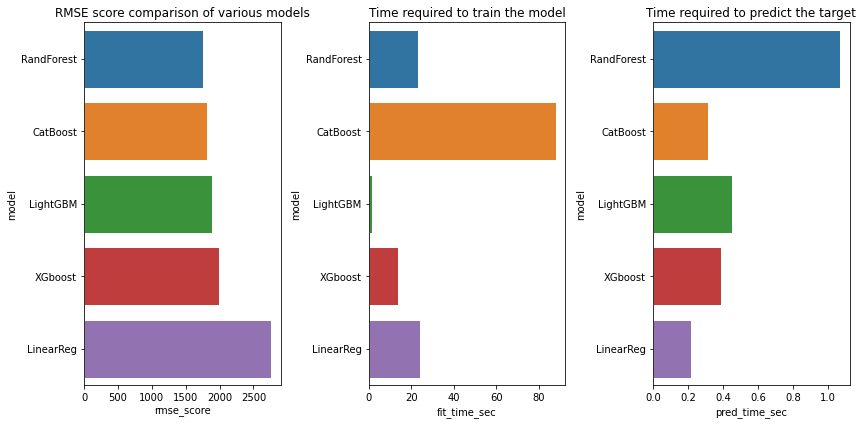

In [38]:
# Kinerja model terbaik
models = ["LinearReg", "RandForest", "LightGBM", "XGboost", "CatBoost"]
rmse_score = [2766.05, 1754.42, 1888.53, 1990.81, 1814.9]
fit_time = [24.1, 23.4, 1.65, 13.9, 88]
pred_time = [0.22, 1.07, 0.45, 0.39, 0.313]
# Membuat dataframe
comparison = pd.DataFrame(
    data=zip(models, rmse_score, fit_time, pred_time),
    columns=["model", "rmse_score", "fit_time_sec", "pred_time_sec"],
)

# plot performance metrics
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
sns.set_style("whitegrid")


sns.barplot(
    data=comparison.sort_values("rmse_score"),
    y="model",
    x="rmse_score",
    orient="h",
    ax=ax[0],
)
ax[0].set_title("RMSE score comparison of various models")
sns.barplot(
    data=comparison.sort_values("rmse_score"),
    y="model",
    x="fit_time_sec",
    orient="h",
    ax=ax[1],
)
ax[1].set_title("Time required to train the model")
sns.barplot(
    data=comparison.sort_values("rmse_score"),
    y="model",
    x="pred_time_sec",
    orient="h",
    ax=ax[2],
)
ax[2].set_title("Time required to predict the target")


plt.tight_layout()
plt.show()

### Kesimpulan Sementara

Secara keseluruhan, dari perspektif skor RMSE, semua model memiliki kinerja yang baik dibandingkan dengan `LinearRegression ` sederhana, yang memperkirakan harga mobil dengan ±2766 EUR. Namun, skor RMSE `RandomForest` adalah yang terendah (±1754 EUR), tetapi `LightGBM` dan `CatBoost` juga memiliki kinerja yang sebanding dengan `RandomForest`.

Di sisi lain, waktu untuk melatih model dan memprediksi target berbeda secara signifikan. Misalnya, RandomForest yang memiliki skor RMSE tertinggi, `memerlukan 23 detik untuk pelatihan` dan `1,1 detik untuk prediksi`, sedangkan model **LinearRegression sederhana memerlukan 24 detik untuk pelatihan dan hanya 0,22 detik untuk prediksi**.

Waktu prediksi lebih penting daripada waktu latihan, dikatenakan model pernah dilatih dan diterapkan. Kemudian pelanggan sering menggunakan model ini untuk memprediksi harga mobilnya. Dan ini harus dilakukan dengan cepat karena untuk mencegah waktu tunggu yang lama. Oleh karena itu, model dengan skor RMSE yang memadai dan waktu prediksi terendah lebih menjanjikan untuk diterapkan.

Singkatnya, dapat mengatakan bahwa `CatBoost dengan prediksi akurat yang relatif baik ( ±1814 EUR) dan waktu prediksi hanya 0,31 detik terlihat lebih menjanjikan untuk implementasi tugas khusus ini.`

## Rangkuman

- Data dengan **354369 baris dan 16 kolom** telah diimpor dan diperiksa, observasi/perubahan berikut dilakukan:
     - Kolom `vehicletype`, `gearbox`, `model`, `fueltype`, dan `notrepaired` berisi nilai yang hilang. Semua kolom ini berisi tipe data kategorikal. Oleh karena itu, semua nilai yang hilang diisi sebagai "tidak diketahui";
     - Total 262 baris diduplikasi dalam data asli. Ditemukan bahwa mereka adalah duplikat yang identik. Semuanya dijatuhkan;
     - Kolom baru yang berisi umur kendaraan, `vehicleage`, dibuat menggunakan kolom `datecreated` dan `registrationyear`. Namun, pada langkah ini, diamati bahwa data mengandung kesalahan pada kolom `tahun pendaftaran`, ada tahun yang paling rendah 1000 dan paling tinggi 9999. Semua tahun lebih kecil dari 1900 (tahun ketika mobil menjadi komersial) dan lebih tinggi daripada tanggal pembuatan profil dibatalkan. Jumlah baris yang dihilangkan sekitar 4% dari data.


- Selama EDA, terlihat adanya kesalahan pada kolom `power` yang berisi nilai horsepower setinggi 20.000. Semua nilai di atas Q3+IQR*1.5 dihilangkan (hanya 0,12% dari data) .

- Teramati bahwa **yang paling banyak terjual**:
     - Merk : Volkswagen
     - Model: golf
     - Vehicles Type : sedan
     - Gearbox: manual (lebih dari dua pertiganya)
     - Fuel Type : bensin (sekitar dua pertiga dari semuanya)

Semua kesalahan yang disebutkan mungkin berasal dari alasan teknis, kesalahan manusia (salah ketik), atau selama perayapan web, penggabungan kumpulan data, dll.

- Kami telah memilih kolom paling penting sebagai berikut: `price`, `vehicletype`, `gearbox`, `power`, `model`, `mileage`, `fueltype`, `brand`, dan `vehicleage`. Data baru untuk model pelatihan dan pengujian memiliki 331474 baris dan 9 kolom (hanya sebagai perbandingan, data awal berisi: **354369 baris dan 16 kolom**. Duplikat, kesalahan, dan data yang tidak perlu dihilangkan.)

- Algoritme berikut dilatih dan diuji:
    |Algorithm            |Deal with categoricals|Scaling        |Tuned Hyperparamteres  |
    |---------------------|----------------------|---------------|-----------------------|
    |LinearRegression     |One hot encoding      |StandardScaler |None                   |
    |RandomForestRegressor|Label encoding        |None           |n_estimators, max_depth|
    |LightGBMRegressor    |Label encoding        |None           |n_estimators, max_depth|
    |XGBoostRegressor     |Label encoding        |None           |None                   |
    |CatBoostRegressor    |it has its own        |None           |iterations, depth      |



- Secara keseluruhan, dari perspektif skor RMSE, semua model memiliki performa yang baik dibandingkan dengan **LinearRegression sederhana, yang memperkirakan harga mobil sebesar $\pm$ 2766 EUR.** Namun, skor RMSE **RandomForest adalah yang terendah ($\pm$ 1754 EUR)**, tetapi LightGBM dan CatBoost juga memiliki kinerja yang sebanding dengan RandomForest. Di sisi lain, waktu untuk melatih model dan memprediksi target berbeda secara signifikan. Misalnya, RandomForest, yang memiliki skor RMSE tertinggi, memerlukan 23 detik untuk pelatihan dan 1,1 detik untuk prediksi, sedangkan model **LinearRegression sederhana memerlukan 24 detik untuk pelatihan dan hanya 0,22 detik untuk prediksi.**


Waktu prediksi lebih penting daripada waktu latihan. Dikarenakan model pernah dilatih dan diterapkan. Kemudian pelanggan sering menggunakan model ini untuk memprediksi harga mobilnya. Dan ini harus dilakukan dengan cepat karena untuk mencegah waktu tunggu yang lama. Oleh karena itu, model dengan skor RMSE yang memadai dan waktu prediksi terendah lebih menjanjikan untuk diterapkan.

**Singkatnya, dapat mengatakan bahwa CatBoost dengan prediksi akurat yang relatif baik ($\pm$ 1814 EUR) dan waktu prediksi hanya 0,31 detik terlihat lebih menjanjikan untuk implementasi tugas khusus ini.**

# Daftar Periksa

Ketik 'x' untuk menandakannya sebagai selesai. Lalu, tekan tombol Shift+Enter

- [x]  Jupyter Notebook bisa dibuka
- [x]  Tidak ada kesalahan pada kode
- [x]  Sel-sel dengan kode telah disusun berdasarkan urutan eksekusi
- [x]  Data telah diunduh dan disiapkan- [ ]  Model sudah dilatih
- [x]  Analisis terhadap kecepatan dan kualitas model telah dilakukan